In [1]:
pip install requests pandas networkx plotly nbformat python-louvain iso3166 dash



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade nbformat


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter
import networkx as nx
import community.community_louvain as community
from networkx.algorithms import community
import itertools
import collections
import networkx as nx
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
from iso3166 import countries_by_alpha2


In [4]:
response = requests.get("https://api.openalex.org/concepts?search=quantum technology")
print(response.json())

{'meta': {'count': 1, 'db_response_time_ms': 46, 'page': 1, 'per_page': 25, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/C190463098', 'wikidata': 'https://www.wikidata.org/wiki/Q2081419', 'display_name': 'Quantum technology', 'relevance_score': 26965.031, 'level': 4, 'description': 'emerging technologies built on quantum mechanics', 'works_count': 10727, 'cited_by_count': 504928, 'summary_stats': {'2yr_mean_citedness': 4.163828808099402, 'h_index': 328, 'i10_index': 3283}, 'ids': {'openalex': 'https://openalex.org/C190463098', 'wikidata': 'https://www.wikidata.org/wiki/Q2081419', 'mag': '190463098', 'wikipedia': 'https://en.wikipedia.org/wiki/Quantum%20technology'}, 'image_url': 'https://upload.wikimedia.org/wikipedia/commons/9/99/QD_S.jpg', 'image_thumbnail_url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/QD_S.jpg/100px-QD_S.jpg', 'international': {'display_name': {'ar': 'تقانة الكم', 'de': 'Quantentechnologie', 'en': 'quantum technology', 'eo': 'kva

In [5]:
def fetch_openalex_data(concept_id, topic_label, max_results=4000):
    url = "https://api.openalex.org/works"
    params = {
        'filter': f'concepts.id:{concept_id}',
        'per-page': 200  #this 200 per-page request is causing issues with sample size. let's see if the max_results override will help me increase API requests
    }
    
    extracted_data = []
    cursor = "*"  #openalex api docuemntation says this will start pagination
    total_fetched = 0 

    while cursor and total_fetched < max_results:
        params['cursor'] = cursor
        response = requests.get(url, params=params)
        data = response.json()

        works = data.get('results', [])
        for work in works:
            if total_fetched >= max_results:
                break  #it should stop if max results reached?

            year = work.get('publication_year', None)
            title = work.get('title', 'Unknown Title')
            authors = ', '.join(
                [author['author']['display_name'] for author in work.get('authorships', []) if author['author'].get('display_name')]
            )

            institutions = [auth.get('institutions', []) for auth in work.get('authorships', [])]
            
            #institution names and countries
            institution_names = set()
            institution_countries = set()
            for inst_group in institutions:
                for inst in inst_group:
                    if inst.get('display_name'):  #avoid NoneType errors
                        institution_names.add(inst.get('display_name', 'Unknown Institution'))
                    if inst.get('country_code'):  #again avoid NoneType errors
                        institution_countries.add(inst.get('country_code', 'Unknown Country'))
            
            citation_count = work.get('cited_by_count', 0)

            extracted_data.append({
                'Year': year,
                'Title': title,
                'Authors': authors,
                'Institution Name': ', '.join(institution_names) if institution_names else 'Unknown Institution',
                'Institution Country': ', '.join(institution_countries) if institution_countries else 'Unknown Country',
                'Citation Count': citation_count,
                'Topic': topic_label
            })

            total_fetched += 1 
        
        cursor = data.get('meta', {}).get('next_cursor') 

    return extracted_data

#each topic's data
ai_data = fetch_openalex_data('C154945302', 'Artificial Intelligence', max_results=4000)
qt_data = fetch_openalex_data('C190463098', 'Quantum Technology', max_results=4000)
eb_data = fetch_openalex_data('C136229726', 'Engineering Biology', max_results=4000)

#combine
all_data = ai_data + qt_data + eb_data

#convert to pandas df
df = pd.DataFrame(all_data)

#save as CSV
df.to_csv("openalex_combined_dataset.csv", index=False)

print("Dataset saved as 'openalex_combined_dataset.csv'")



Dataset saved as 'openalex_combined_dataset.csv'


In [6]:
print(df.columns)
print(df.info())
print(df.describe())


Index(['Year', 'Title', 'Authors', 'Institution Name', 'Institution Country',
       'Citation Count', 'Topic'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 12000 non-null  int64 
 1   Title                11956 non-null  object
 2   Authors              12000 non-null  object
 3   Institution Name     12000 non-null  object
 4   Institution Country  12000 non-null  object
 5   Citation Count       12000 non-null  int64 
 6   Topic                12000 non-null  object
dtypes: int64(2), object(5)
memory usage: 656.4+ KB
None
               Year  Citation Count
count  12000.000000     12000.00000
mean    2007.407750      2213.10050
std       13.366352      4987.81241
min     1859.000000         0.00000
25%     2002.000000        91.00000
50%     2010.000000       507.00000
75%    

In [7]:
#count unique articles
print("Unique Articles:", df['Title'].nunique())

#count unique authors
print("Unique Authors:", df['Authors'].str.split(', ').explode().nunique())

#count unique countries
print("Unique Countries:", df['Institution Country'].str.split(', ').explode().nunique())

#count unique institutions
print("Unique Institutions:", df['Institution Name'].str.split(', ').explode().nunique())


Unique Articles: 11768
Unique Authors: 36521
Unique Countries: 95
Unique Institutions: 4628


In [8]:
#the top 10 most frequent authors
top_authors = df['Authors'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Authors:\n", top_authors)

#top 10 most frequent institutions
top_institutions = df['Institution Name'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Institutions:\n", top_institutions)

#get the top 10 most frequent university countries
top_countries = df['Institution Country'].str.split(', ').explode().value_counts().head(10)
print("Top 10 University Countries:\n", top_countries)


Top 10 Authors:
 Authors
                      62
Guang‐Can Guo         57
Ali Khademhosseini    57
Róbert Langer         56
Jian-Wei Pan          51
Mikhail D. Lukin      47
David Mooney          45
David L. Kaplan       39
Anton Zeilinger       38
Fedor Jelezko         38
Name: count, dtype: int64
Top 10 Institutions:
 Institution Name
Unknown Institution                              1350
University of California                          645
Massachusetts Institute of Technology             443
Harvard University                                431
Stanford University                               309
Centre National de la Recherche Scientifique      240
University of Michigan–Ann Arbor                  221
University of Science and Technology of China     216
Berkeley                                          214
University of Oxford                              213
Name: count, dtype: int64
Top 10 University Countries:
 Institution Country
US                 5268
Unknown Country    1

In [9]:
#filter for rows with "Unknown Institution"
unknown_institutions = df[df['Institution Name'].str.contains("Unknown Institution", na=False)]
print(f"Rows with 'Unknown Institution':\n{unknown_institutions}")

#filter for rows with "Unknown Country"
unknown_countries = df[df['Institution Country'].str.contains("Unknown Country", na=False)]
print(f"Rows with 'Unknown Country':\n{unknown_countries}")


Rows with 'Unknown Institution':
       Year                                              Title  \
14     2017                          Attention Is All You Need   
19     1989  Genetic algorithms in search, optimization, an...   
20     1996                                         Fuzzy sets   
28     2003  Model Selection and Multimodel Inference: A Pr...   
33     1994  Situated Learning: Legitimate Peripheral Parti...   
...     ...                                                ...   
11929  1978  The release of gentamicin from polymethylmetha...   
11934  1979        Improved electrode for electroretinography.   
11958  2015  Periodontal and peri‐implant wound healing fol...   
11965  2009  UHMWPE Biomaterials Handbook: Ultra High Molec...   
11967  1983  Mechanical effectiveness of root canal irrigation   

                                                 Authors     Institution Name  \
14     Ashish Vaswani, Noam Shazeer, Niki Parmar, Jak...  Unknown Institution   
19          

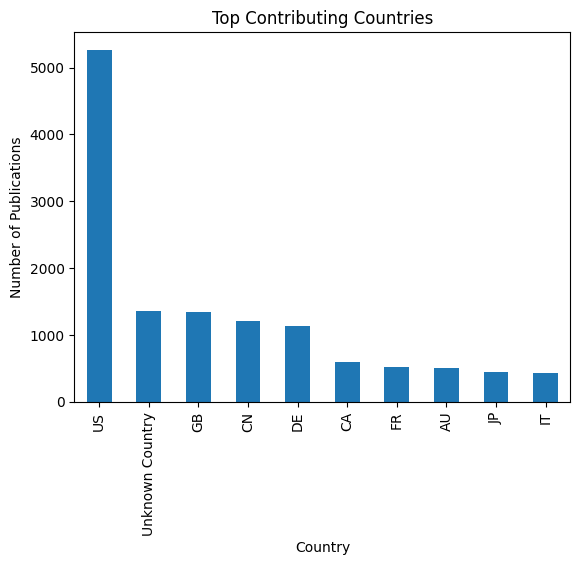

In [10]:
#countries
top_countries = df['Institution Country'].str.split(', ').explode().value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top Contributing Countries")
plt.xlabel("Country")
plt.ylabel("Number of Publications")
plt.show()


In [11]:
#initialize a list to hold country-to-country pairs
country_pairs = []

#loop through each row in the dataframe
for countries in df['Institution Country']:
    if pd.notna(countries):  # Ensure countries are not missing
        #split the countries and filter out "Unknown Country"
        country_list = list(set(countries.split(', ')))
        country_list = [country for country in country_list if country != "Unknown Country"]
        
        #generate all possible pairs of countries
        country_pairs += list(combinations(country_list, 2))

#amount the occurrences of each country pair
pair_counts = Counter(country_pairs)

#top 10 most frequent country collaborations
top_country_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])

print("Top Country-to-Country Collaborations:\n", top_country_pairs)



Top Country-to-Country Collaborations:
 {('GB', 'US'): 328, ('DE', 'US'): 288, ('CN', 'US'): 263, ('US', 'CA'): 215, ('US', 'FR'): 137, ('US', 'KR'): 127, ('JP', 'US'): 118, ('GB', 'DE'): 113, ('GB', 'CN'): 106, ('US', 'AU'): 98}


In [12]:
#check if any "Unknown Country" or "Unknown Institution" remains
print("Rows with 'Unknown Country':", df['Institution Country'].str.contains("Unknown Country").sum())
print("Rows with 'Unknown Institution':", df['Institution Name'].str.contains("Unknown Institution").sum())


Rows with 'Unknown Country': 1353
Rows with 'Unknown Institution': 1350


In [13]:
#filter out rows containing "Unknown Country" or "Unknown Institution"
filtered_df = df[
    ~df['Institution Country'].str.contains("Unknown Country", na=False) &
    ~df['Institution Name'].str.contains("Unknown Institution", na=False)
]

#country-to-country pairs
country_pairs = []

#loop through each row
for countries in filtered_df['Institution Country']:
    if pd.notna(countries):
        country_list = list(set(countries.split(', ')))
        
        # generate all possible pairs of countries
        country_pairs += list(combinations(country_list, 2))

#count the frequency 
pair_counts = Counter(country_pairs)

#top 10 frequent country collaborations
top_country_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])

#print top country-to-country collaborations
print("Top Country-to-Country Collaborations:\n", top_country_pairs)


Top Country-to-Country Collaborations:
 {('GB', 'US'): 328, ('DE', 'US'): 288, ('CN', 'US'): 263, ('US', 'CA'): 215, ('US', 'FR'): 137, ('US', 'KR'): 127, ('JP', 'US'): 118, ('GB', 'DE'): 113, ('GB', 'CN'): 106, ('US', 'AU'): 98}


In [14]:
#recheck. unknown country or unknown institution still exist? 
print("Rows with 'Unknown Country':", filtered_df['Institution Country'].str.contains("Unknown Country").sum())
print("Rows with 'Unknown Institution':", filtered_df['Institution Name'].str.contains("Unknown Institution").sum())


Rows with 'Unknown Country': 0
Rows with 'Unknown Institution': 0


In [15]:
print(filtered_df.nunique)
print(filtered_df.info())

<bound method DataFrame.nunique of        Year                                              Title  \
0      2016       Deep Residual Learning for Image Recognition   
1      2001                                               None   
2      1995  Controlling the False Discovery Rate: A Practi...   
3      1990                  Basic local alignment search tool   
4      1997  Gapped BLAST and PSI-BLAST: a new generation o...   
...     ...                                                ...   
11995  2010  Microfluidic sorting and multimodal typing of ...   
11996  2010  Evaluation of calculation methods of mean skin...   
11997  2012  Balancing osteoblast functions and bacterial a...   
11998  2011  Tissue engineering of functional articular car...   
11999  2008  Quantitative evaluation of oxygenation in veno...   

                                                 Authors  \
0      Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun   
1                                            Leo Bre

In [16]:
#how many missing titles .info shows
missing_titles = filtered_df['Title'].isna().sum()
print(f"Number of missing Titles: {missing_titles}")

Number of missing Titles: 38


/Users/williamgbenton/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/williamgbenton/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/williamgbenton/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33538 (\N{CJK UNIFIED IDEOGRAPH-8302}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/williamgbenton/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31298 (\N{CJK UNIFIED IDEOGRAPH-7A42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/williamgbenton/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:15

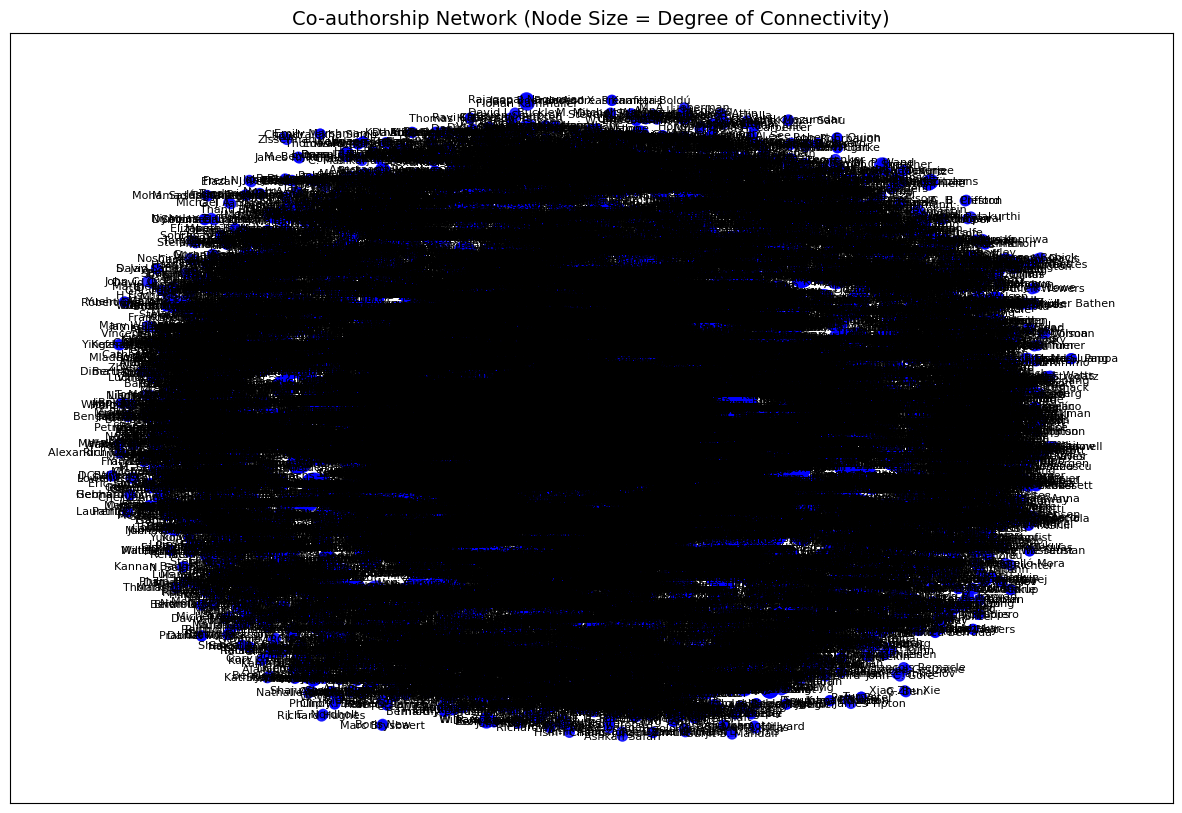

In [17]:
#initialize the graph
G = nx.Graph()

#add edges based on co-authorship
for _, row in df.iterrows():
    if pd.notna(row['Authors']):  #ensure authors column is not empty
        authors = list(set(row['Authors'].split(', ')))
        #add edges for each pair of co-authors
        for author1, author2 in combinations(authors, 2):
            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1 
            else:
                G.add_edge(author1, author2, weight=1)

#calculate node degrees (connectivity)
degree = dict(G.degree())
node_size = [v * 50 for v in degree.values()]  #scale by degree (adjust scaling as needed)

#layout for viz
pos = nx.spring_layout(G, seed=42)  # Use spring layout for clear visualization

#draw the network
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.8, node_color="blue")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=8)

#add title
plt.title("Co-authorship Network (Node Size = Degree of Connectivity)", fontsize=14)
plt.show()


Number of Nodes (Authors): 35553
Number of Edges (Collaborations): 224783

Top 10 Authors by Degree Centrality:
R. X. Adhikari: 0.0081
G. Billingsley: 0.0080
K. Arai: 0.0080
L. Barsotti: 0.0080
F. Clara: 0.0080
J. Betzwieser: 0.0080
A. F. Brooks: 0.0080
Ali Khademhosseini: 0.0073
S. Ballmer: 0.0069
Guang‐Can Guo: 0.0065

Number of Communities Detected: 3121
Largest Community Size: 5863


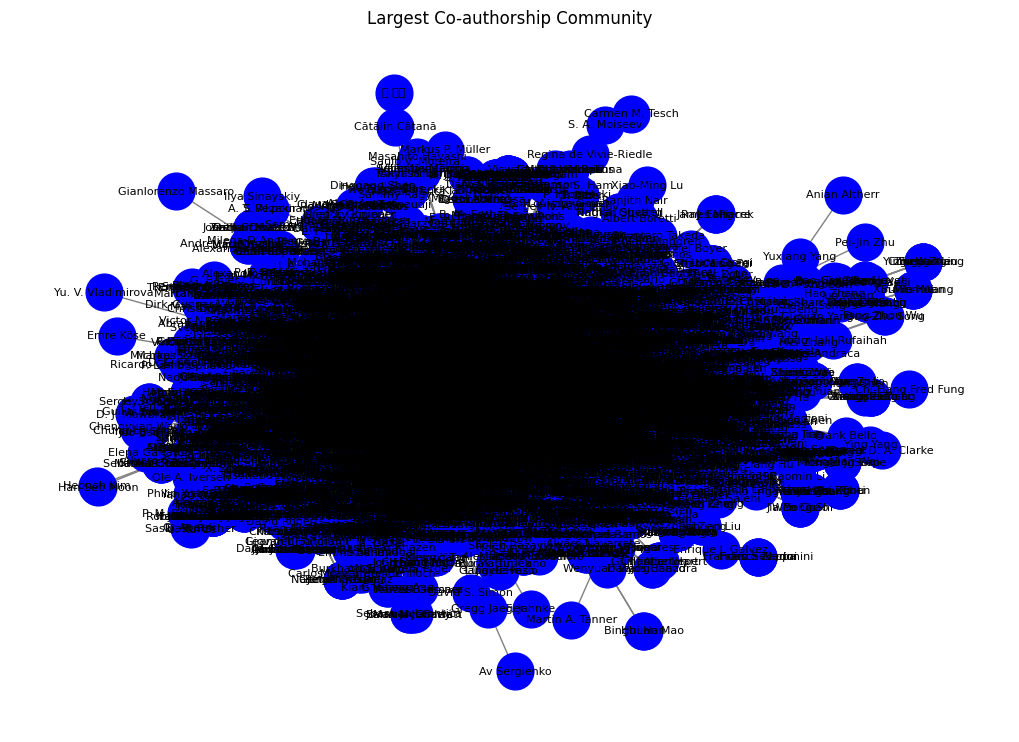

In [18]:
#basic information 
print("Number of Nodes (Authors):", G.number_of_nodes())
print("Number of Edges (Collaborations):", G.number_of_edges())

#want top 10 authors
degree_centrality = nx.degree_centrality(G)
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Authors by Degree Centrality:")
for author, score in top_authors:
    print(f"{author}: {score:.4f}")

#should detect largest community?
communities = list(community.greedy_modularity_communities(G))
print(f"\nNumber of Communities Detected: {len(communities)}")

#identify the largest community
largest_community = max(communities, key=len)
print(f"Largest Community Size: {len(largest_community)}")

#visualize the largest community
H = G.subgraph(largest_community)
pos = nx.spring_layout(H, seed=42)  #subgraph visualization/layout

plt.figure(figsize=(10, 7))
nx.draw(
    H, pos, with_labels=True, node_size=700, node_color="blue", edge_color="gray", font_size=8
)
plt.title("Largest Co-authorship Community")
plt.show()


In [21]:
country_edges = []
for _, row in df.iterrows():
    country_codes = list(set(row['Institution Country'].split(', ')))
    country_edges.extend(itertools.combinations(country_codes, 2))

country_pair_counts = Counter(country_edges)

print("Top Country-to-Country Collaborations:")
print(dict(country_pair_counts.most_common(10)))  #what are the top 10 countries


Top Country-to-Country Collaborations:
{('GB', 'US'): 328, ('DE', 'US'): 288, ('CN', 'US'): 263, ('US', 'CA'): 215, ('US', 'FR'): 137, ('US', 'KR'): 127, ('JP', 'US'): 118, ('GB', 'DE'): 113, ('GB', 'CN'): 106, ('US', 'AU'): 98}


In [26]:
#UK's official name is too long. Need to shorten
country_name_overrides = {
    "GB": "United Kingdom"
}

# dash app
app = Dash(__name__)

#layout. years and topic filter
app.layout = html.Div([
    html.H1("Country Collaboration Network"),
    dcc.Dropdown(
        id="topic-filter",
        options=[
            {"label": "Artificial Intelligence", "value": "Artificial Intelligence"},
            {"label": "Engineering Biology", "value": "Engineering Biology"},
            {"label": "Quantum Technology", "value": "Quantum Technology"}
        ],
        value="Artificial Intelligence",
        clearable=False
    ),
    dcc.RangeSlider(
        id="year-slider",
        min=1993,
        max=2023,
        step=1,
        value=[1993, 2023],
        marks={year: str(year) for year in range(1993, 2024, 5)}
    ),
    dcc.Dropdown(
        id="label-selection",
        options=[],
        multi=True,
        placeholder="Select countries to display labels"
    ),
    html.Div([
        dcc.Graph(id="country-network-graph", clear_on_unhover=True, config={'scrollZoom': True}, style={'flex': '1'}),
        html.Div(id="hovered-country-pairings-container", children=[
            html.H3(id="hovered-country-name", children="Top 3 Collaborators"),
            html.Ul(id="hovered-country-pairings")
        ], style={'position': 'absolute', 'top': '10px', 'right': '10px', 'background-color': 'white', 'padding': '10px', 'border': '1px solid black', 'z-index': '10'})
    ], style={'display': 'flex', 'position': 'relative'})
])

@app.callback(
    [Output("country-network-graph", "figure"),
     Output("hovered-country-name", "children"),
     Output("hovered-country-pairings", "children"),
     Output("label-selection", "options")],
    [Input("topic-filter", "value"), Input("year-slider", "value"), Input("country-network-graph", "hoverData"), Input("label-selection", "value")]
)
def update_graph(selected_topic, selected_years, hoverData, selected_labels):
    if selected_labels is None:
        selected_labels = []
    
    filtered_df = df[(df['Topic'] == selected_topic) & (df['Year'] >= selected_years[0]) & (df['Year'] <= selected_years[1])]
    
    #
    country_edges = []
    for _, row in filtered_df.iterrows():
        country_codes = list(set(row['Institution Country'].split(', ')))
        country_names = [
            country_name_overrides.get(code, countries_by_alpha2[code].name if code in countries_by_alpha2 else code)
            for code in country_codes
        ]
        country_edges.extend(itertools.combinations(country_names, 2))
    
    country_pairs = collections.Counter(country_edges)
    G = nx.Graph()
    for pair, weight in country_pairs.items():
        G.add_edge(pair[0], pair[1], weight=weight)
    
    pos = nx.spring_layout(G, seed=42, k=0.3 * (1 / np.sqrt(len(G.nodes()))))
    
    country_options = [{"label": country, "value": country} for country in G.nodes()]
    
    #this should make the hover tooltip work...maybe? 
    hovered_node = None
    if hoverData and 'points' in hoverData and hoverData['points']:
        first_point = hoverData['points'][0]
        if 'text' in first_point:
            hovered_node = first_point['text'].split('<br>')[0]
    
    highlighted_nodes = set(selected_labels)
    highlighted_edges = set()
    if hovered_node:
        highlighted_nodes.add(hovered_node)
        highlighted_nodes.update([neighbor for neighbor in G.neighbors(hovered_node)])
    for selected_node in selected_labels:
        highlighted_nodes.update([neighbor for neighbor in G.neighbors(selected_node)])
        highlighted_edges.update([(selected_node, neighbor) for neighbor in G.neighbors(selected_node)])
    
    hovered_pairings = []
    hovered_country_label = "Top 3 Collaborators"
    selected_country = hovered_node if hovered_node else (selected_labels[0] if selected_labels else None)
    if selected_country:
        hovered_country_label = f"Top 3 Collaborators for {selected_country}"
        
        all_collaborators = sorted(
            [(a, b, d['weight']) for a, b, d in G.edges(data=True) if a == selected_country or b == selected_country],
            key=lambda x: x[2], reverse=True
        )
        
        unique_collaborators = list(dict.fromkeys([(collab[0], collab[1]) for collab in all_collaborators if collab[0] != collab[1]]))
        
        top_collaborators = unique_collaborators[:3]
        
        hovered_pairings = [html.Li(f"{collab[0]} - {collab[1]}") for collab in top_collaborators]
    
    edge_x, edge_y = [], []
    for edge in highlighted_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    node_x, node_y, node_size, node_text, node_colors, node_labels = [], [], [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_size.append((G.degree(node) / max(1, max(dict(G.degree()).values()))) * 30 + 10)
        node_text.append(f"{node}<br><b>Total Count of Collaborations:</b> {sum(d['weight'] for _, _, d in G.edges(node, data=True))}<br><b>Unique Country Pairings:</b> {G.degree(node)}")
        node_labels.append(node if node in selected_labels or node == hovered_node else "")
        node_colors.append("green" if node in selected_labels else ("red" if node in highlighted_nodes else "blue"))
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y, mode="lines",
        line=dict(width=0.5, color="red"),
        hoverinfo="none"
    ))
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y, mode="markers+text",
        marker=dict(size=node_size, color=node_colors),
        text=node_labels, textposition="top center",
        hoverinfo="text",
        customdata=node_text,
        hovertemplate="%{customdata}<extra></extra>",
        name=""
    ))
    fig.update_layout(title=f"{selected_topic} Collaborations ({selected_years[0]}-{selected_years[1]})", showlegend=False, uirevision="network")
    
    return fig, hovered_country_label, hovered_pairings if hovered_pairings else [html.Li("None")], country_options

if __name__ == "__main__":
    app.run_server(debug=True, port=8054)
